<a href="https://colab.research.google.com/github/MilanCugur/Offline_Writer_Identification/blob/master/NIST_Clustering_Knn_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up ImageDisk and Info Disk

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
from zipfile import ZipFile

from keras.utils import Sequence
from random import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [0]:
%%time
# Extract images to './ImageDisk' folder

path = './drive/My Drive/New_Approach_29.12.2018/ImageDisk.zip'  # Different .zip folder with images
archive = ZipFile(path, 'r')
archive.extractall('./ImageDisk')  
archive.close()

CPU times: user 1min 23s, sys: 41.6 s, total: 2min 4s
Wall time: 2min 13s


In [0]:
# Extract info about the images to InfoDisk list (path, ascii, writer_id); 
# example: ('f0500_38/l0500_38/l0500_38_00008.png', '106', '500')
path = './drive/My Drive/New_Approach_29.12.2018/InfoDisk.txt'  
InfoDisk = []

with open(path, "r") as f:
  for line in f.readlines():
    line = line.rstrip('\n').split(' ')
    InfoDisk.append((line[0], line[1], line[2]))
f.close()

# OneHot Class

In [0]:
# OneHot Encoding
class OneHot():  
  # classes = list of classes : 0-9, a-z, A-Z
  # n = number of classes     : 62
  
  def __init__(self, classes):
    self.classes = classes
    self.n = len(classes)
    
  def encode(self, class_name):
    one_hot = np.zeros(shape=(self.n), dtype=np.int8)
    class_index = self.classes.index(class_name)
    one_hot[class_index] = 1
    return one_hot
  
  def encode_all(self, list_class_names):
    return np.array([self.encode(class_name) for class_name in list_class_names])
  
  def decode(self, one_hot):
    class_index = one_hot.argmax()
    return self.classes[class_index]
  
  def decode_all(self, list_one_hots):
    return np.array([self.decode(one_hot) for one_hot in list_one_hots])

In [0]:
labels = set()
for (path, label, writer) in InfoDisk:
  labels.add(label)
OH_L = OneHot(sorted(labels))

print(sorted(labels))  # 62 ascii codes in string format
print(len(labels))

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '97', '98', '99']
62


# Data 

In [0]:
writers = {}
for path, label, writer in InfoDisk:
  writer = int(writer)
  if writer in writers:
    writers[writer] += 1
  else:
    writers[writer] = 1
  
writers = list(writers.items())
writers = sorted(writers, key=lambda x: x[1])  # sort writers with respect to number of characters they wrote
print(writers)

[(1727, 18), (825, 21), (1725, 24), (1965, 30), (2027, 33), (1726, 39), (2046, 40), (2044, 41), (1995, 43), (1990, 46), (1992, 46), (1984, 49), (1974, 49), (1767, 50), (1723, 51), (1969, 51), (1556, 67), (1756, 67), (2067, 72), (1110, 76), (4043, 77), (1977, 79), (1209, 79), (1749, 86), (1006, 86), (1731, 87), (2504, 90), (2097, 91), (1598, 92), (3704, 92), (3901, 94), (1931, 95), (416, 95), (1348, 95), (1831, 97), (3642, 98), (1016, 98), (1280, 99), (1854, 99), (1675, 100), (1923, 100), (3696, 102), (1621, 102), (1733, 102), (2105, 102), (1576, 103), (1432, 103), (1783, 103), (3797, 103), (1542, 103), (2048, 104), (1607, 105), (2095, 105), (785, 105), (2069, 106), (1919, 106), (1646, 107), (2047, 107), (2077, 107), (1517, 107), (1523, 107), (1386, 107), (4064, 107), (1859, 107), (2040, 107), (1548, 108), (3240, 108), (3820, 108), (3747, 108), (1802, 108), (1944, 109), (1639, 109), (2032, 109), (1788, 110), (1671, 111), (1686, 112), (3296, 112), (2099, 112), (2080, 113), (1655, 113), (

In [0]:
testW = []
countImgs = 0  # No of images in test set
while countImgs<len(InfoDisk)*0.1:
  testW.append(writers[-1])
  countImgs += writers[-1][1]
  writers = writers[:-1]

In [0]:
print(testW)
len(testW)

[(261, 583), (289, 464), (27, 446), (292, 442), (155, 442), (119, 437), (10, 436), (644, 436), (1301, 435), (337, 435), (199, 433), (70, 433), (164, 430), (46, 430), (254, 429), (190, 428), (66, 428), (54, 428), (344, 427), (335, 427), (203, 426), (320, 426), (110, 426), (743, 425), (315, 425), (11, 425), (281, 424), (17, 424), (246, 423), (99, 423), (1369, 422), (395, 422), (256, 422), (863, 422), (115, 421), (465, 420), (360, 420), (317, 420), (495, 419), (451, 419), (996, 419), (23, 418), (379, 418), (255, 418), (8, 418), (443, 417), (330, 417), (312, 416), (197, 416), (102, 416), (35, 416), (613, 416), (161, 415), (361, 415), (698, 415), (679, 415), (547, 415), (473, 414), (843, 414), (187, 414), (108, 414), (63, 413), (1, 413), (925, 413), (633, 413), (208, 413), (534, 413), (472, 412), (494, 412), (347, 412), (1091, 411), (172, 411), (328, 411), (94, 410), (622, 410), (77, 409), (118, 408), (211, 408), (804, 408), (530, 408), (401, 407), (31, 407), (815, 407), (752, 407), (690, 4

200

In [0]:
# Split and stratify
# 80% : 10% : 10%
# shuffle(writers)
trainW = []
validationW = []

for i in range(0, len(writers)):
  if i%10==9:
    validationW.append(writers[i])
  else:
    trainW.append(writers[i])

trainW = set(trainW)
validationW = set(validationW)
testW = set(testW)

In [0]:
testW = [x[0] for x in testW]
validationW = [x[0] for x in validationW]
trainW = [x[0] for x in trainW]

In [0]:
print(len(trainW))
print(len(validationW))
print(len(testW))

3057
339
200


In [0]:
%%time
train_Images = []
train_Labels = []
train_Writers = []

validation_Images = []
validation_Labels = []
validation_Writers = []

test_Images = []
test_Labels = []
test_Writers = []

shuffle(InfoDisk)  # for randomization of labels; writers are fitted anywhay
for path, label, writer in InfoDisk:
  writer = int(writer)
  img = mpimg.imread(os.path.join('./ImageDisk', path))
  if writer in testW:
    test_Images.append(img.reshape(28, 28, 1)/255.0)
    test_Labels.append(OH_L.encode(label))
    test_Writers.append(writer)
  elif writer in validationW:
    validation_Images.append(img.reshape(28, 28, 1)/255.0)
    validation_Labels.append(OH_L.encode(label))
    validation_Writers.append(writer)
  elif writer in trainW:
    train_Images.append(img.reshape(28, 28, 1)/255.0)
    train_Labels.append(OH_L.encode(label))
    train_Writers.append(writer)
  else:
    print('Unrecognized writer, ', writer)  # Throw exception

CPU times: user 2min 6s, sys: 35.8 s, total: 2min 42s
Wall time: 5min 24s


In [0]:
print(len(train_Writers))
print(len(validation_Writers))
print(len(test_Writers))
print()
print(len(train_Labels))
print(len(validation_Labels))
print(len(test_Labels))
print()
print(len(train_Images))
print(len(validation_Images))
print(len(test_Images))

659541
73209
81505

659541
73209
81505

659541
73209
81505


# Load Model

In [0]:
from keras.models import Model
from keras.models import load_model

recognizer = load_model('./drive/My Drive/New_Approach_29.12.2018/baseline_model.h5')
finder = Model(inputs=recognizer.input, outputs=recognizer.get_layer('next_to_last').output)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
recognizer.evaluate(x=np.array(train_Images), y=np.array(train_Labels), batch_size=256, verbose=1)

659541/659541 [==============================] - 28s 42us/step


[0.29930853555806036, 0.8836448378503469]

In [0]:
recognizer.evaluate(x=np.array(validation_Images), y=np.array(validation_Labels), batch_size=256, verbose=1)

73209/73209 [==============================] - 5s 70us/step


[0.32758882487221935, 0.8739362647597281]

In [0]:
recognizer.evaluate(x=np.array(test_Images), y=np.array(test_Labels), batch_size=256, verbose=1)

81505/81505 [==============================] - 6s 79us/step


[0.3596773234578512, 0.8735046929563088]

# Best Model: Clustering by labels + KNN+

## Clustering by instances

In [0]:
labels = sorted([int(l) for l in labels])  # int
print(labels)

[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]


In [0]:
IVectors = {}  # Ascii code is key, 48, 49, 50, ...
for l in labels:
  IVectors[l] = []
print(IVectors)

{48: [], 49: [], 50: [], 51: [], 52: [], 53: [], 54: [], 55: [], 56: [], 57: [], 65: [], 66: [], 67: [], 68: [], 69: [], 70: [], 71: [], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 78: [], 79: [], 80: [], 81: [], 82: [], 83: [], 84: [], 85: [], 86: [], 87: [], 88: [], 89: [], 90: [], 97: [], 98: [], 99: [], 100: [], 101: [], 102: [], 103: [], 104: [], 105: [], 106: [], 107: [], 108: [], 109: [], 110: [], 111: [], 112: [], 113: [], 114: [], 115: [], 116: [], 117: [], 118: [], 119: [], 120: [], 121: [], 122: []}


In [0]:
%%time

for k in range(0, len(validation_Images)):
  l = int(OH_L.decode(validation_Labels[k]))
  next_to_last = finder.predict(np.array([validation_Images[k]]))[0]
  IVectors[l].append(next_to_last)

CPU times: user 3min 14s, sys: 15.5 s, total: 3min 29s
Wall time: 2min 28s


In [0]:
%%time

for k in range(0, len(train_Images)):
  l = int(OH_L.decode(train_Labels[k]))
  next_to_last = finder.predict(np.array([train_Images[k]]))[0]
  IVectors[l].append(next_to_last)

CPU times: user 29min 23s, sys: 2min 10s, total: 31min 33s
Wall time: 22min 22s


In [0]:
S = 0
for l in IVectors.keys():
  S += len(IVectors[l])
print(S)

732750


In [0]:
print(len(validation_Images))
print(len(train_Images))
print(len(validation_Images)+len(train_Images))

print(labels)
print(len(labels))

73209
659541
732750
[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
62


In [0]:
print([len(IVectors[l]) for l in labels])  # broj slika po svakoj labeli

[37928, 42193, 37689, 38659, 36787, 34383, 37547, 39455, 37189, 37196, 6719, 4108, 10154, 4779, 5041, 8949, 2783, 3339, 11891, 3967, 2667, 5269, 8963, 8473, 24266, 8408, 2844, 5155, 20171, 9791, 12428, 4872, 4948, 3016, 4839, 2982, 9597, 5310, 3100, 10033, 22948, 2787, 3786, 8541, 2957, 2056, 2770, 14900, 2927, 10948, 3019, 2644, 3128, 13352, 2948, 17183, 3127, 3195, 2980, 3102, 2577, 2987]


In [0]:
N_clusters = [int(min(30, 1+max(len(IVectors[l])/1000, 4))) for i, l in enumerate(labels)]  # CHANGE THIS!
print(N_clusters)
print(sum(N_clusters))  

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 7, 5, 11, 5, 6, 9, 5, 5, 12, 5, 5, 6, 9, 9, 25, 9, 5, 6, 21, 10, 13, 5, 5, 5, 5, 5, 10, 6, 5, 11, 23, 5, 5, 9, 5, 5, 5, 15, 5, 11, 5, 5, 5, 14, 5, 18, 5, 5, 5, 5, 5, 5]
715


In [0]:
from sklearn.cluster import KMeans
ICentroids = {}  # dictionary with centroids for each label
kmeans = None

In [0]:
%%time

for i, l in enumerate(labels):
  if kmeans!=None:
    del kmeans
  kmeans = KMeans(n_clusters=N_clusters[i], n_init=10, max_iter=300, tol=1e-4, precompute_distances=False, verbose=0)  # 15, 250/10, 300
  
  kmeans.fit(IVectors[l])
  ICentroids[l] = kmeans.cluster_centers_

CPU times: user 16min 25s, sys: 2min 8s, total: 18min 33s
Wall time: 15min 27s


In [0]:
ICentroids[48].shape  # Clusters for 'A'; small check

(30, 256)

In [0]:
# Normalize clusters; Newly added; Quick fix, small improvements; Normalize together ???
for k in ICentroids.keys(): 
  for j in range(0, ICentroids[k].shape[0]):
    ICentroids[k][j] = (ICentroids[k][j] - ICentroids[k][j].mean())/(ICentroids[k][j].std())

In [0]:
from sklearn.neighbors import KNeighborsClassifier  # Estimate the quality of custers
from sklearn.metrics import accuracy_score

Ns = [1,2,3,4,5,7,8,9,10,15]

X_train = []
y_train = []

for l in labels:
  for j in range(0, ICentroids[l].shape[0]):
    X_train.append(ICentroids[l][j])
    y_train.append(l)

for n in Ns:
  knn = KNeighborsClassifier(n_neighbors=n, metric='l2')
  knn.fit(X_train, y_train)
  
  score = accuracy_score(knn.predict(finder.predict(np.array(test_Images))), [int(x) for x in OH_L.decode_all(test_Labels)])
  print('KNN', n, ': ', score)
  del knn

KNN 1 :  0.8205876940065027
KNN 2 :  0.8312250782160604
KNN 3 :  0.8213361143488129
KNN 4 :  0.8535672658119133
KNN 5 :  0.8367584810747807
KNN 7 :  0.8458376786700202
KNN 8 :  0.8605361634255567
KNN 9 :  0.852696153610208
KNN 10 :  0.8558370652107232
KNN 15 :  0.8153242132384516


# Density class

In [0]:
import numpy as np
from  scipy import stats
from matplotlib import pyplot as plt

In [0]:
# approximating theta parametar - how much I believe in network/knn (initially 0.5)

class CharStatistic():
  # label
  # alpha = 1 (initial)
  # beta = 1 (initial)
  
  def __init__(self, label, alpha=None, beta=None):
    self.label = label
    
    if alpha is not None:
      self.alpha = alpha
    else:
      self.alpha = 1
    if beta is not None:
      self.beta = beta
    else:
      self.beta = 1 # hardcoded initial; start with uniform distribution U[0, 1]
   
  def get_alpha(self):  # getters
    return self.alpha
  
  def get_beta(self):
    return self.beta
  
  def set_alpha(self, alpha):
    self.alpha = alpha
    
  def set_beta(self, beta):
    self.beta = beta
  
  def get_mean(self):
    return self.alpha/(self.alpha+self.beta)  # initaially 0.5
    # return stats.beta.mean(self.alpha, self.beta)
  
  def get_standard_deviation(self):
    return np.sqrt(self.alpha*self.beta/((self.alpha+self.beta)**2*(self.alpha+self.beta+1)))  # initially 0.1
    # return stats.beta.std(self.alpha, self.beta)
  
  def update_one(self, winnew):  # winnew==1 if knn wins, else its 0
    self.alpha += winnew
    self.beta += 1 - winnew
    
  def update_all(self, winnews):  # winnews = [1, 0, 1, ..] 1 if knn wins else 0
    N = len(winnews)
    z = sum(winnews)
    self.alpha += z
    self.beta += N - z
    
  def print_current_density_function(self):  # print current approximation of beta distribution
    x = np.linspace(0, 1, 100)
    y = stats.beta.pdf(x, self.alpha, self.beta)
    plt.xlabel("Density approximation for LABEL: "+self.label)
    plt.ylabel("Density")
    plt.plot(x, y)
    plt.fill_between(x, 0, y, color="#aaaadd", alpha=0.5)
    plt.tight_layout()
    plt.show()
  
  # FUNCTIONS FOR DECISION MAKING, WHOM TO TRUST:
    
  def __gt__(self, otherCharStatistic):  # Override operator > on density approximation
    if not isinstance(otherCharStatistic, CharStatistic):
      raise ValueError("Error. Operator overloaded for CharStatistic class")
    if self.get_mean()>otherCharStatistic.get_mean(): # TODO: USE .get_standard_deviation()
      return True
    else:
      return False

In [0]:
S = CharStatistic('A')
S1 = CharStatistic('B')
S.get_standard_deviation()

0.28867513459481287

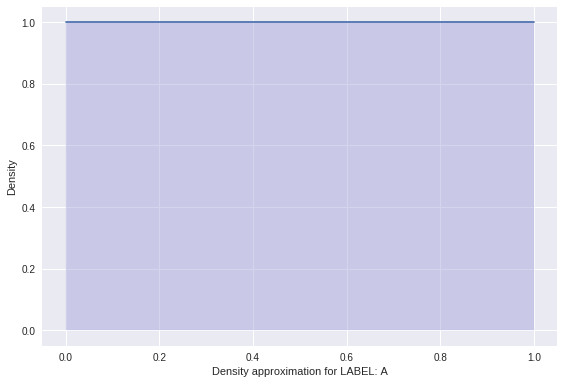

In [0]:
S.print_current_density_function()

In [0]:
S > S1

False

# With Stratify, multiple k idea

In [0]:
labels = []
for char in range(ord('0'), ord('9')+1):
  labels.append(chr(char))
for char in range(ord('A'), ord('Z')+1):
  labels.append(chr(char))
for char in range(ord('a'), ord('z')+1):
  labels.append(chr(char))
print(labels)  
print(len(labels))

testset = set(test_Writers)
print(len(testset))  # No of different writers

# TESTDATA[Writer] = [testImagesOfWriter, testLabelsOfWriter]; example: TESTDATA[9] = [testImages9, testLabels9]
TESTDATA = {} 
for writer in testset:
  TESTDATA[writer] = [[], []]
for i in range(0, len(test_Writers)):
    TESTDATA[test_Writers[i]][0].append(test_Images[i])
    TESTDATA[test_Writers[i]][1].append(test_Labels[i])

def find_minimal(i, vector):  # i is the ascii code: 48.49,...,65,66,...,97,...
  # Implicit use of dictionary ICentroids[ASCII]
  minindex = 0
  mineps = np.linalg.norm(vector-ICentroids[i][0])
  for j in range(1, ICentroids[i].shape[0]):  
    _mineps = np.linalg.norm(vector-ICentroids[i][j])
    if _mineps < mineps:
      mineps = _mineps
      minindex = j
      
  return ICentroids[i][minindex].copy()   # CHANGE NUMBER OF CLUSTERS MLADEN IDEA

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
62
200


In [0]:
winold = 0
equal = 0
winnew = 0
sumS = 0
sumS1 = 0
sumSboth = 0
sumN = 0
lenBetterOld = 0
lenBetterNew = 0

In [0]:
import math
ks = [2, 4, 6, 8, 10]  # outer object for configure get_min_label function and evaluation

def get_min_label(history, predicted_vector): # return list of predicted label for k in ks
  X_search = []
  y_search = []
  for (_predicted_label, _original_label) in history.keys():  # Na 90% mreza je rekla _predicted_label a bila je _original_label (imam vector i count)
      if _predicted_label == predicted_label:
        for _ in range(history[(_predicted_label, _original_label)][1]):
          X_search.append(history[(_predicted_label, _original_label)][0])
          y_search.append(_original_label)      
  
  results = {}
  for k in ks:
    if len(X_search)<k:  # if I cant do knn search with respect to specific k
      results[k] = None
    else:
      knn = KNeighborsClassifier(n_neighbors=k, metric='l2')  # empirically confirm; use heuristic instead of min
      knn.fit(X_search, y_search)
      results[k] = knn.predict(np.array([predicted_vector]))[0]
      
  return results # return dict of predictions for each k in ks [1, 2, 4, 6, 8]

# Who to believe in prediction
# input: (baseline prediction, baseline spectar, knns oredictions, knns spectars)
def who_to_believe(predicted_label, writer_network_spectar, min_labels, writer_knn_spectars): # Return optimal k or None if baseline is the best
  trust = [writer_network_spectar[chr(predicted_label)].get_mean()]
  for k in ks:
    if min_labels[k] is None: # no prediction for that k
      trust.append(-1)  # baseline is above 0 in any case
    else:
      trust.append(writer_knn_spectars[k][chr(min_labels[k])].get_mean())  # mean of density approximation for predicted label for specific k 
    
  maxindex = trust.index(max(trust))
  if maxindex is 0:  # baseline is the best
    return None
  else:              # find proper k (-1 is ok cause of 0 index is for baseline)
    return ks[maxindex-1]

In [0]:
import random
from itertools import chain
from random import shuffle

# Helper function; Simulate unfair coin flip
def flip_a_unfair_coin(p): # p is for example 3/10 etc.
  return random.random()<p

# Hardcoded split 90%:10%
# Get images and labels of some writer, and create 90%:10% split
# return images and labels (same list) and also m (border line: [0, m), [m, n) split)
def stratify_me(images, labels):
  X_train = []  # train:test = 90%:10% of writer images
  X_test = []
  y_train = []
  y_test = []
  
  indexlabels = [i for i in chain(range(ord('0'), ord('9')+1), range(ord('A'), ord('Z')+1), range(ord('a'), ord('z')+1))]  # [48, 49, 50, ..., 65, 66, ..., 97, 98, ...]
  freqlabels = [[] for _ in indexlabels]  # 0-9, A-Z, a-z
  
  n = len(labels)  # size of writer pictures
  m = 0            # border for dynamic history ~int(0.9*n)+1
  
  for i in range(len(labels)):
    indx = indexlabels.index(int(labels[i]))  # position in freqlabels with respect to ascii code of label
    freqlabels[indx].append(i)                # freqlabels[ascii_code_of_0] contains all indexes for label '0' in writer images
    
  for freq in freqlabels:
    shuffle(freq)
    
    # first part, enough label
    while len(freq)>=10:
      _freq = freq[:10]
      freq = freq[10:]
      
                                       # random choose one of ten images for evaluation (I can choose one index, but I want to shuffle also for dynamic history)
      X_test.append(images[_freq[0]])  # add one image for evaluation set
      y_test.append(labels[_freq[0]])
      for f in _freq[1:]:
        X_train.append(images[f])  # add nine images to dynamic istory set
        y_train.append(labels[f])
      m += 9                              # added nine images into dynamic history
    
    # second part, should I sample from tail (example 3 images instead of 10)
    if flip_a_unfair_coin(len(freq)/10)==True:
      X_test.append(images[freq[0]])
      y_test.append(labels[freq[0]])
      freq = freq[1:]
      
    for f in freq:
      X_train.append(images[f])
      y_train.append(labels[f])
    m += len(freq)  # added rest of the images into dynamic history set
    
  return X_train+X_test, y_train+y_test, m, n

In [0]:
%%time

for writer in TESTDATA.keys():   # [2, 665, 1369]: writer - current writer id
  #images9 = TESTDATA[writer][0]  # images9 - images of current writer
  #labels9 = TESTDATA[writer][1]  # labels9 - labels of current writer
  #n = len(images9)               
  #m = int(0.90*n)+1                 # 90% for dynaminc history, 10% for evaluation of new model
  images9, labels9, m, n = stratify_me(TESTDATA[writer][0], OH_L.decode_all(TESTDATA[writer][1]))
  
  
  #################################################### GET DYNAMIC HISTORY {(predicted_label, original_label):[[vector], count]}
  history = {}
  for i in range(0, m):
    original_label = int(labels9[i])
    predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0]))
    predicted_vector = find_minimal(original_label, finder.predict(np.array([images9[i]]))[0])  
    if (predicted_label, original_label) not in history.keys():
      history[(predicted_label, original_label)]=[predicted_vector, 1]
    else:
      history[(predicted_label, original_label)][0] += predicted_vector
      history[(predicted_label, original_label)][1] += 1      
  for (x,y) in sorted(history.keys()):  # find AVG of predicted clusters; DROP THIS PART IN NEW VERSION; MLADEN IDEA
    history[(x,y)][0] /= history[(x,y)][1]  
  
  #################################################### GET SPECTARS
  writer_network_spectar = {}
  writer_knn_spectars = {}  # dict of dictionaries
  for k in ks:
    writer_knn_spectars[k] = {}  # spectars for each k in ks
  for l in labels:   # add statistic for character l to all spectars
    writer_network_spectar[l] = CharStatistic(l) # [0, 0]
    for k in ks:
      writer_knn_spectars[k][l] = CharStatistic(l)
    
  for i in range(0, m):
    original_label = int(labels9[i])
    predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0]))
    predicted_vector = finder.predict(np.array([images9[i]]))[0]
    
    ##### writer_network_spectar
    if original_label == predicted_label:
      writer_network_spectar[chr(predicted_label)].update_one(1) # Network says predicted_label and its correct
    else:
      writer_network_spectar[chr(predicted_label)].update_one(0)  # Network says predicted_label and its wrong
         
    ##### writer_knn_spectar
    min_labels = get_min_label(history, predicted_vector)
    for k in ks:  # get min label is configured with respect to ks
      min_label = min_labels[k]
      if min_label is None:
        min_label = predicted_label  # min label je moje predvidjanje 
      if min_label == original_label:  # min_label je ono sto ja predvidjam na onih 10%; to i evaluiram 
        writer_knn_spectars[k][chr(min_label)].update_one(1)
      else:
        writer_knn_spectars[k][chr(min_label)].update_one(0)
  
  #################################################### GET S AND S1
  S = 0
  S1 = 0
  Sboth = 0
  N = len(labels9[m:n])
  for i in range(m, n):  # slow variant
    original_label = int(labels9[i])
    predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0])) # int(string like '48') -> ascii code
    predicted_vector = finder.predict(np.array([images9[i]]))[0]
    
    ##### S1; old one
    #print('NN DEBUG: predicted: ', predicted_label, 'original: ', original_label)
    #input()
    if predicted_label == original_label:
      S1 += 1
    predicted_label_bkp = predicted_label
    ##### S; new approach
    min_labels = get_min_label(history, predicted_vector)  # get list of predictions or each k
    k = who_to_believe(predicted_label, writer_network_spectar, min_labels, writer_knn_spectars)  # Choose who have biggest mean of all spectars, use it as a aprediction
    if k is not None and min_labels[k] is not None:  # believe to specific knn, which have it own prediction
      predicted_label = min_labels[k]  # new approach; change network prediction if knn is sure enough  
    if predicted_label == original_label:
      S += 1
  
    ##### Sboth
    if predicted_label_bkp == original_label or (k is not None and min_labels[k] is not None and min_labels[k]==original_label):
      Sboth+=1 
  
    ########## UPDATE history AND *spectar ##########
    # original_label OK
    predicted_label = predicted_label_bkp
    # predicted_vector OK 
    
    # history
    predicted_vector_bkp = find_minimal(original_label, predicted_vector)
    if (predicted_label, original_label) not in history.keys():
      history[(predicted_label, original_label)]=[predicted_vector_bkp, 1]
    else:
      history[(predicted_label, original_label)][0] = (history[(predicted_label, original_label)][0]*history[(predicted_label, original_label)][1]+predicted_vector_bkp)/(history[(predicted_label, original_label)][1]+1)
      history[(predicted_label, original_label)][1] += 1
    
    # writer_network_spectar
    if original_label == predicted_label:
      writer_network_spectar[chr(predicted_label)].update_one(1)  # Network says predicted_label and its correct
    else:
      writer_network_spectar[chr(predicted_label)].update_one(0)  # Network says predicted_label and its wrong
  
    # writer_knn_spectar
    min_labels = get_min_label(history, predicted_vector)  # prvo ga ubacim u istoriju - ali kao proseci itd. a onda kasnije trazim min_label; MOZDA INVERZNO? da ne bih nasao istog
    for k in ks:
      min_label = min_labels[k]
      if min_label is None:
        min_label = predicted_label  # min label je moje predvidjanje 
      if min_label == original_label:  # min_label je ono sto ja predvidjam na onih 10%; to i evaluiram 
        writer_knn_spectars[k][chr(min_label)].update_one(1)
      else:
        writer_knn_spectars[k][chr(min_label)].update_one(0)
    ########## END UPDATE ##########
    
  #################################################### PRINT AND UPDATE GLOBAL VALUES
  if S!=S1:  # Print only diff
    print("Writer {0:4d} == mynew: {1:d} ({2:3.2f}%) == old: {3:d} ({4:3.2f}%) == both: {5:d} ({6:3.2f}%), No. of images {7:d}, len(image9)={8:d}".format(writer, S, float(100*S)/N, S1, float(100*S1)/N, Sboth, float(100.0*Sboth)/N, N, n))
  sumS += S
  sumS1 += S1
  sumSboth += Sboth
  sumN += N   
  
  if S==S1:
    equal += 1
  elif S>S1:
    winnew += 1
    lenBetterNew += n
  else:
    winold += 1
    lenBetterOld += n   
    
  del history
  del writer_network_spectar
  del writer_knn_spectars

Writer    1 == mynew: 37 (86.05%) == old: 35 (81.40%) == both: 37 (86.05%), No. of images 43, len(image9)=413
Writer    2 == mynew: 35 (87.50%) == old: 33 (82.50%) == both: 35 (87.50%), No. of images 40, len(image9)=404
Writer    3 == mynew: 40 (90.91%) == old: 36 (81.82%) == both: 40 (90.91%), No. of images 44, len(image9)=397
Writer  518 == mynew: 40 (95.24%) == old: 37 (88.10%) == both: 40 (95.24%), No. of images 42, len(image9)=403
Writer  519 == mynew: 35 (89.74%) == old: 33 (84.62%) == both: 36 (92.31%), No. of images 39, len(image9)=394
Writer   10 == mynew: 41 (91.11%) == old: 40 (88.89%) == both: 41 (91.11%), No. of images 45, len(image9)=436
Writer   17 == mynew: 38 (86.36%) == old: 41 (93.18%) == both: 41 (93.18%), No. of images 44, len(image9)=424
Writer  530 == mynew: 29 (80.56%) == old: 30 (83.33%) == both: 32 (88.89%), No. of images 36, len(image9)=408
Writer   23 == mynew: 41 (85.42%) == old: 46 (95.83%) == both: 46 (95.83%), No. of images 48, len(image9)=418
Writer   2

In [0]:
print('winold: ', winold)
print('equal: ', equal)
print('winnew: ', winnew)
print('S: (new): ', 100.0*sumS/sumN)
print('S1: (old): ', 100.0*sumS1/sumN)
print('Sboth: (new): ', 100.0*sumSboth/sumN)
print('AVG len winold: ', 1.0*lenBetterOld/winold)
print('AVG len winnew: ', 1.0*lenBetterNew/winnew)
print('No of evaluation images: ', sumN)

winold:  18
equal:  63
winnew:  119
S: (new):  89.61552725924095
S1: (old):  87.09358387934232
Sboth: (new):  91.23501050809742
AVG len winold:  404.6111111111111
AVG len winnew:  408.25210084033614
No of evaluation images:  8089


In [0]:
# +2.52%/+4.14%

# With Stratify, multiple k idea, RESAMPLE

In [0]:
labels = []
for char in range(ord('0'), ord('9')+1):
  labels.append(chr(char))
for char in range(ord('A'), ord('Z')+1):
  labels.append(chr(char))
for char in range(ord('a'), ord('z')+1):
  labels.append(chr(char))
print(labels)  
print(len(labels))

testset = set(test_Writers)
print(len(testset))  # No of different writers

# TESTDATA[Writer] = [testImagesOfWriter, testLabelsOfWriter]; example: TESTDATA[9] = [testImages9, testLabels9]
TESTDATA = {} 
for writer in testset:
  TESTDATA[writer] = [[], []]
for i in range(0, len(test_Writers)):
    TESTDATA[test_Writers[i]][0].append(test_Images[i])
    TESTDATA[test_Writers[i]][1].append(test_Labels[i])

def find_minimal(i, vector):  # i is the ascii code: 48.49,...,65,66,...,97,...
  # Implicit use of dictionary ICentroids[ASCII]
  minindex = 0
  mineps = np.linalg.norm(vector-ICentroids[i][0])
  for j in range(1, ICentroids[i].shape[0]):  
    _mineps = np.linalg.norm(vector-ICentroids[i][j])
    if _mineps < mineps:
      mineps = _mineps
      minindex = j
      
  return ICentroids[i][minindex].copy()   # CHANGE NUMBER OF CLUSTERS MLADEN IDEA

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
62
200


In [0]:
winold = 0
equal = 0
winnew = 0
sumS = 0
sumS1 = 0
sumSboth = 0
sumN = 0
lenBetterOld = 0
lenBetterNew = 0

In [0]:
import math
ks = [2,4,6,8,10]  # outer object for configure get_min_label function and evaluation

def get_min_label(history, predicted_vector): # return list of predicted label for k in ks
  X_search = []
  y_search = []
  for (_predicted_label, _original_label) in history.keys():  # Na 90% mreza je rekla _predicted_label a bila je _original_label (imam vector i count)
      if _predicted_label == predicted_label:
        for _ in range(history[(_predicted_label, _original_label)][1]):
          X_search.append(history[(_predicted_label, _original_label)][0])
          y_search.append(_original_label)      
  
  results = {}
  for k in ks:
    if len(X_search)<k:  # if I cant do knn search with respect to specific k
      results[k] = None
    else:
      knn = KNeighborsClassifier(n_neighbors=k, metric='l2')  # empirically confirm; use heuristic instead of min
      knn.fit(X_search, y_search)
      results[k] = knn.predict(np.array([predicted_vector]))[0]
      
  return results # return dict of predictions for each k in ks [1, 2, 4, 6, 8]

# Who to believe in prediction
# input: (baseline prediction, baseline spectar, knns oredictions, knns spectars)
def who_to_believe(predicted_label, writer_network_spectar, min_labels, writer_knn_spectars): # Return optimal k or None if baseline is the best
  trust = [writer_network_spectar[chr(predicted_label)].get_mean()]
  for k in ks:
    if min_labels[k] is None: # no prediction for that k
      trust.append(-1)  # baseline is above 0 in any case
    else:
      trust.append(writer_knn_spectars[k][chr(min_labels[k])].get_mean())  # mean of density approximation for predicted label for specific k 
    
  maxindex = trust.index(max(trust))
  if maxindex is 0:  # baseline is the best
    return None
  else:              # find proper k (-1 is ok cause of 0 index is for baseline)
    return ks[maxindex-1]

In [0]:
import random
from itertools import chain
from random import shuffle

# Helper function; Simulate unfair coin flip
def flip_a_unfair_coin(p): # p is for example 3/10 etc.
  return random.random()<p

# Hardcoded split 90%:10%
# Get images and labels of some writer, and create 90%:10% split
# return images and labels (same list) and also m (border line: [0, m), [m, n) split)
def stratify_me(images, labels):
  X_train = []  # train:test = 90%:10% of writer images
  X_test = []
  y_train = []
  y_test = []
  
  indexlabels = [i for i in chain(range(ord('0'), ord('9')+1), range(ord('A'), ord('Z')+1), range(ord('a'), ord('z')+1))]  # [48, 49, 50, ..., 65, 66, ..., 97, 98, ...]
  freqlabels = [[] for _ in indexlabels]  # 0-9, A-Z, a-z
  
  n = len(labels)  # size of writer pictures
  m = 0            # border for dynamic history ~int(0.9*n)+1
  
  for i in range(len(labels)):
    indx = indexlabels.index(int(labels[i]))  # position in freqlabels with respect to ascii code of label
    freqlabels[indx].append(i)                # freqlabels[ascii_code_of_0] contains all indexes for label '0' in writer images
    
  for freq in freqlabels:
    shuffle(freq)
    
    # first part, enough label
    while len(freq)>=10:
      _freq = freq[:10]
      freq = freq[10:]
      
                                       # random choose one of ten images for evaluation (I can choose one index, but I want to shuffle also for dynamic history)
      X_test.append(images[_freq[0]])  # add one image for evaluation set
      y_test.append(labels[_freq[0]])
      for f in _freq[1:]:
        X_train.append(images[f])  # add nine images to dynamic istory set
        y_train.append(labels[f])
      m += 9                              # added nine images into dynamic history
    
    # second part, should I sample from tail (example 3 images instead of 10)
    if flip_a_unfair_coin(len(freq)/10)==True:
      X_test.append(images[freq[0]])
      y_test.append(labels[freq[0]])
      freq = freq[1:]
      
    for f in freq:
      X_train.append(images[f])
      y_train.append(labels[f])
    m += len(freq)  # added rest of the images into dynamic history set
    
  return X_train+X_test, y_train+y_test, m, n

In [0]:
NoResample = 10

In [0]:
%%time

for writer in TESTDATA.keys():   # writer - current writer id
  #images9 = TESTDATA[writer][0]  # images9 - images of current writer
  #labels9 = TESTDATA[writer][1]  # labels9 - labels of current writer
  #n = len(images9)               
  #m = int(0.9*n)+1                 # 90% for dynaminc history, 10% for evaluation of new model
  
  S = 0      # no of images on which new method is correct
  S1 = 0     # no of images on which baseline network is correct
  Sboth = 0  # no of images on which either baseline or knn is correct
  Nall = 0   # no of evaluation images
  for _ in range(NoResample):  # Resample
    #################################################### STRATIFY AND SHUFFLE INTERNALLY 
    images9, labels9, m, n = stratify_me(TESTDATA[writer][0], OH_L.decode_all(TESTDATA[writer][1]))
    
    #################################################### GET DYNAMIC HISTORY {(predicted_label, original_label):[[vector], count]}
    history = {}
    for i in range(0, m):
      original_label = int(labels9[i])
      predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0]))
      predicted_vector = find_minimal(original_label, finder.predict(np.array([images9[i]]))[0])  
      if (predicted_label, original_label) not in history.keys():
        history[(predicted_label, original_label)]=[predicted_vector, 1]
      else:
        history[(predicted_label, original_label)][0] += predicted_vector
        history[(predicted_label, original_label)][1] += 1      
    for (x,y) in sorted(history.keys()):  # find AVG of predicted clusters
      history[(x,y)][0] /= history[(x,y)][1]  
  
    #################################################### GET SPECTARS
    writer_network_spectar = {}
    writer_knn_spectars = {}  # dict of dictionaries
    for k in ks:
      writer_knn_spectars[k] = {}  # spectars for each k in ks
    for l in labels:   # add statistic for character l to all spectars
      writer_network_spectar[l] = CharStatistic(l) # [0, 0]
      for k in ks:
        writer_knn_spectars[k][l] = CharStatistic(l)
    
    for i in range(0, m):
      original_label = int(labels9[i])
      predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0]))
      predicted_vector = finder.predict(np.array([images9[i]]))[0]
    
      ##### writer_network_spectar
      if original_label == predicted_label:
        writer_network_spectar[chr(predicted_label)].update_one(1)  # Network says predicted_label and its correct
      else:
        writer_network_spectar[chr(predicted_label)].update_one(0)  # Network says predicted_label and its wrong
         
      ##### writer_knn_spectar
      min_labels = get_min_label(history, predicted_vector)
      for k in ks:  # get min label is configured with respect to ks
        min_label = min_labels[k]
        if min_label is None:
          min_label = predicted_label  # min label je moje predvidjanje 
        if min_label == original_label:  # min_label je ono sto ja predvidjam na onih 10%; to i evaluiram 
          writer_knn_spectars[k][chr(min_label)].update_one(1)
        else:
          writer_knn_spectars[k][chr(min_label)].update_one(0)
  
    #################################################### GET S AND S1
    s = 0                  # tmp no of images on which knn is correct
    s1 = 0                 # tmp no of images on which baseline is correct
    sboth = 0              # tmp no of images on which either knn or baseline is correct
    N = len(labels9[m:n])  # tmp no of evaluation images
    for i in range(m, n): 
      original_label = int(labels9[i])
      predicted_label = int(OH_L.decode(recognizer.predict(np.array([images9[i]]))[0])) # int(string like '48') -> ascii code 48
      predicted_vector = finder.predict(np.array([images9[i]]))[0]
    
      ##### s1; old one
      if predicted_label == original_label:
        s1 += 1
      predicted_label_bkp = predicted_label
      ##### s; new approach
      min_labels = get_min_label(history, predicted_vector)  # get list of predictions or each k
      k = who_to_believe(predicted_label, writer_network_spectar, min_labels, writer_knn_spectars)  # Choose who have biggest mean of all spectars, use it as a aprediction
      if k is not None and min_labels[k] is not None:  # believe to specific knn, which have it own prediction
        predicted_label = min_labels[k]  # new approach; change network prediction if knn is sure enough  
      if predicted_label == original_label:
        s += 1
  
      ##### sboth
      if predicted_label_bkp == original_label or (k is not None and min_labels[k] is not None and min_labels[k]==original_label):
        sboth+=1 

      ########## UPDATE history AND *spectar ##########
      # original_label OK
      predicted_label = predicted_label_bkp
      # predicted_vector OK 
    
      # history
      predicted_vector_bkp = find_minimal(original_label, predicted_vector)  # smal bug; fixed; predicted vector is nearest cluster/avg of clusters not next tot last
      if (predicted_label, original_label) not in history.keys():
        history[(predicted_label, original_label)]=[predicted_vector_bkp, 1]
      else:
        history[(predicted_label, original_label)][0] = (history[(predicted_label, original_label)][0]*history[(predicted_label, original_label)][1]+predicted_vector_bkp)/(history[(predicted_label, original_label)][1]+1)
        history[(predicted_label, original_label)][1] += 1
    
      # writer_network_spectar
      if original_label == predicted_label:
        writer_network_spectar[chr(predicted_label)].update_one(1)  # Network says predicted_label and its correct
      else:
        writer_network_spectar[chr(predicted_label)].update_one(0)  # Network says predicted_label and its wrong
  
      # writer_knn_spectar
      min_labels = get_min_label(history, predicted_vector)  # prvo ga ubacim u istoriju - ali kao proseci itd. a onda kasnije trazim min_label; MOZDA INVERZNO? da ne bih nasao istog
      for k in ks:
        min_label = min_labels[k]
        if min_label is None:
          min_label = predicted_label  # min label je moje predvidjanje 
        if min_label == original_label:  # min_label je ono sto ja predvidjam na onih 10%; to i evaluiram 
          writer_knn_spectars[k][chr(min_label)].update_one(1)
        else:
          writer_knn_spectars[k][chr(min_label)].update_one(0)
      ########## END UPDATE ##########        
        
        
    S += s
    S1 += s1
    Sboth += sboth
    Nall += N
    del history
    del writer_network_spectar
    del writer_knn_spectars
    # images9, labels9 = shuffle_both(images9, labels9)  # shuffle images for resampling; final 10% i use for evaluation, first 90% for dynamic history; DONT USE ANYMORE

  #################################################### PRINT AND UPDATE GLOBAL VALUES
  if S!=S1:  # Print only diff
    print("Writer {0:4d} == mynew: {1:d} ({2:3.2f}%) == old: {3:d} ({4:3.2f}%) == both: {5:d} ({6:3.2f}%), No. of images {7:d}, len(image9)={8:d}".format(writer, S, float(100*S)/Nall, S1, float(100*S1)/Nall, Sboth, float(100.0*Sboth)/Nall, Nall, n))
  sumS += S
  sumS1 += S1
  sumSboth += Sboth
  sumN += Nall
  
  if S==S1:     # Update win counts
    equal += 1
  elif S>S1:
    winnew += 1
    lenBetterNew += n
  else:
    winold += 1
    lenBetterOld += n   

Writer    1 == mynew: 378 (92.65%) == old: 367 (89.95%) == both: 385 (94.36%), No. of images 408, len(image9)=413
Writer    2 == mynew: 358 (87.10%) == old: 338 (82.24%) == both: 365 (88.81%), No. of images 411, len(image9)=404
Writer    3 == mynew: 367 (91.07%) == old: 336 (83.37%) == both: 370 (91.81%), No. of images 403, len(image9)=397
Writer  518 == mynew: 396 (96.59%) == old: 360 (87.80%) == both: 398 (97.07%), No. of images 410, len(image9)=403
Writer  519 == mynew: 352 (89.11%) == old: 343 (86.84%) == both: 357 (90.38%), No. of images 395, len(image9)=394
Writer    8 == mynew: 372 (90.73%) == old: 363 (88.54%) == both: 385 (93.90%), No. of images 410, len(image9)=418
Writer   10 == mynew: 401 (88.91%) == old: 384 (85.14%) == both: 410 (90.91%), No. of images 451, len(image9)=436
Writer   11 == mynew: 381 (89.23%) == old: 376 (88.06%) == both: 388 (90.87%), No. of images 427, len(image9)=425
Writer   17 == mynew: 375 (87.41%) == old: 374 (87.18%) == both: 384 (89.51%), No. of im

In [0]:
print('winold: ', winold)
print('equal: ', equal)
print('winnew: ', winnew)
print('S: (new): ', 100.0*sumS/sumN)
print('S1: (old): ', 100.0*sumS1/sumN)
print('Sboth: (new): ', 100.0*sumSboth/sumN)
print('AVG len winold: ', 1.0*lenBetterOld/winold)
print('AVG len winnew: ', 1.0*lenBetterNew/winnew)
print('No of evaluation images: ', sumN)

winold:  24
equal:  9
winnew:  167
S: (new):  89.60396645650977
S1: (old):  87.24000734528984
Sboth: (new):  91.42070147517904
AVG len winold:  404.5416666666667
AVG len winnew:  408.1736526946108
No of evaluation images:  81685


In [0]:
# +2.36%/+4.18%